In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from fancyimpute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
data = pd.read_csv('payment-practices.csv')

In [3]:
# Drop columns that are not useful for the model
columns_to_drop = ['Report Id','Start date', 'End date', 'Filing date', 'Company', 'Company number','URL']
data = data.drop(columns=columns_to_drop)

In [4]:
# assigning types of features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object','bool']).columns
missing_data_cols = [i for i in categorical_features if data[i].isnull().sum() > 0]
non_missing_cat = [i for i in categorical_features if i not in missing_data_cols]

In [5]:
# Missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,14673,18.888789
Average time to pay,6859,8.829701
% Invoices paid within 30 days,6859,8.829701
% Invoices paid between 31 and 60 days,6859,8.829701
% Invoices paid later than 60 days,6859,8.829701
% Invoices not paid within agreed terms,6708,8.635316
Shortest (or only) standard payment period,6708,8.635316
Longest standard payment period,30562,39.342954
Maximum contractual payment period,6708,8.635316
Payment terms have changed,6708,8.635316


Handling missing data

In [6]:
data = data.dropna(subset=['E-Invoicing offered'])

In [7]:
data['Payments made in the reporting period'].fillna(0, inplace=True)
data['Suppliers notified of changes'].fillna(1, inplace=True)

In [8]:
for col in numerical_features:
    data[col] = data[col].fillna(data[col].mean())

In [9]:
mice_imputer = IterativeImputer()
data_imputed = mice_imputer.fit_transform(data)
data_imputed = pd.DataFrame(data_imputed, columns=data.columns)
data = data_imputed

In [10]:
#missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,0,0.0
Average time to pay,0,0.0
% Invoices paid within 30 days,0,0.0
% Invoices paid between 31 and 60 days,0,0.0
% Invoices paid later than 60 days,0,0.0
% Invoices not paid within agreed terms,0,0.0
Shortest (or only) standard payment period,0,0.0
Longest standard payment period,0,0.0
Maximum contractual payment period,0,0.0
Payment terms have changed,0,0.0


EDA

80th Quantile =  47.0


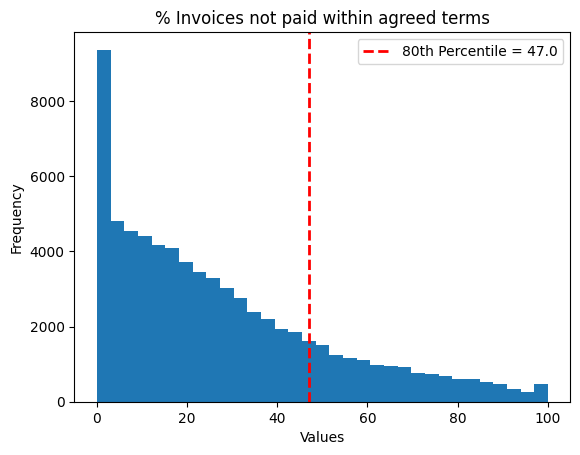

In [11]:
# Bar plot for '% Invoices not paid within agreed terms' and 80th percentile
percentile_80 = np.percentile(data['% Invoices not paid within agreed terms'].dropna(), 80)
print('80th Quantile = ',percentile_80)

plt.hist(data['% Invoices not paid within agreed terms'],bins=33)
plt.axvline(x=percentile_80, color='red', linestyle='dashed', linewidth=2, label='80th Percentile = '+str(percentile_80))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('% Invoices not paid within agreed terms')

# Show the plot
plt.legend()
plt.show()

In [12]:
# Creating target column 'flag' based on the 80th percentile
data['flag'] = 0
data.loc[data['% Invoices not paid within agreed terms'] > percentile_80, 'flag'] = 1
data.drop(columns=['% Invoices not paid within agreed terms'],inplace=True)

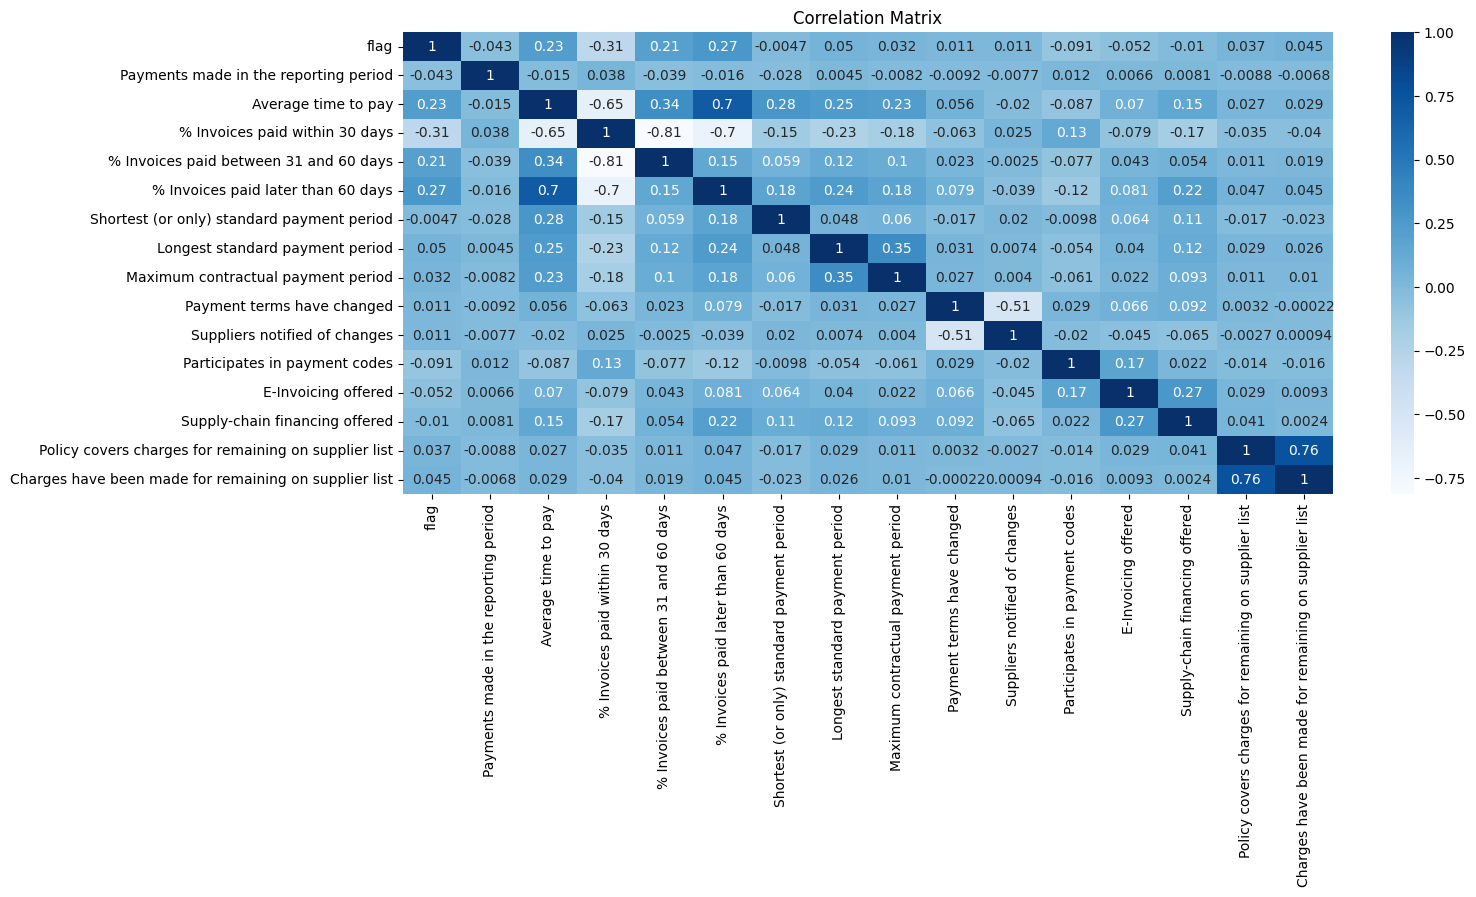

In [13]:
# Correlation Analysis
new_order=[     'flag',
                'Payments made in the reporting period', 'Average time to pay',
                '% Invoices paid within 30 days',
                '% Invoices paid between 31 and 60 days',
                '% Invoices paid later than 60 days',
                'Shortest (or only) standard payment period',
                'Longest standard payment period', 'Maximum contractual payment period',
                'Payment terms have changed', 'Suppliers notified of changes',
                'Participates in payment codes', 'E-Invoicing offered',
                'Supply-chain financing offered',
                'Policy covers charges for remaining on supplier list',
                'Charges have been made for remaining on supplier list']
# Visualize the relationship between numerical columns using a correlation matrix
correlation_matrix = data.reindex(columns=new_order).corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix,annot=True,cmap='Blues')
plt.title('Correlation Matrix')
plt.show()



In [14]:
correlation_threshold = 0.7
for feature, feature_values in correlation_matrix.items():
  for other_feature, correlation in feature_values.items():
    if feature != other_feature and abs(correlation) >= correlation_threshold:
      print(f"{feature} is highly correlated with {other_feature} (correlation: {correlation:.2f})")


% Invoices paid within 30 days is highly correlated with % Invoices paid between 31 and 60 days (correlation: -0.81)
% Invoices paid between 31 and 60 days is highly correlated with % Invoices paid within 30 days (correlation: -0.81)
Policy covers charges for remaining on supplier list is highly correlated with Charges have been made for remaining on supplier list (correlation: 0.76)
Charges have been made for remaining on supplier list is highly correlated with Policy covers charges for remaining on supplier list (correlation: 0.76)


In [15]:
# Dropping the Highly correlated Features
data1 = data.drop(columns=[ '% Invoices paid within 30 days', 
                            '% Invoices paid later than 60 days',
                            'Suppliers notified of changes',
                            'Policy covers charges for remaining on supplier list',])

In [16]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(data1.drop(columns=['flag']), data1['flag'], test_size=1/3, random_state=42)

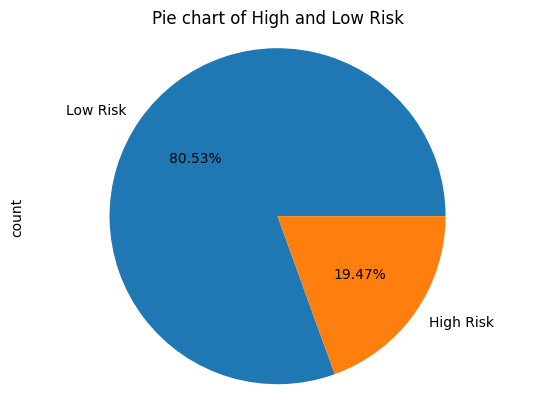

In [17]:
# Pie chart of High and Low Risk before Sampling
y_train.value_counts().plot.pie(autopct='%1.2f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk')
plt.show()

In [18]:
# Implemeting the RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='minority')
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

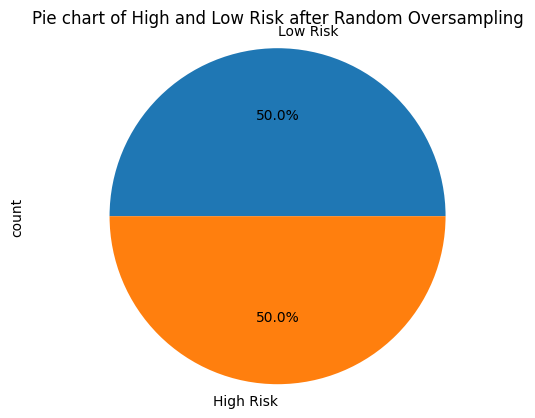

In [19]:
# pie chart of High and Low Risk after Random Oversampling
y_train_oversampled.value_counts().plot.pie(autopct='%1.1f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk after Random Oversampling')
plt.show()

XGBoost

In [20]:
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X_train_oversampled,label=y_train_oversampled)

# XGBoost Model
params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,
    'subsample': 0.85,
    'n_estimators': 900,
} 

xgb_clf = XGBClassifier(**params)

xgb_clf.fit(X_train_oversampled, y_train_oversampled)

y_pred_xgb = xgb_clf.predict(X_test)

# Calculate Accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print('XGBoost model accuracy score: ', accuracy_xgb)

# Calculate F1 Score
f1_xgb = f1_score(y_test, y_pred_xgb)
print('F1 Score:', f1_xgb)

# Calculate AUC
y_pred_xgb = xgb_clf.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)
print('AUC:', auc_xgb)

XGBoost model accuracy score:  0.7635049454729901
F1 Score: 0.551574897811974
AUC: 0.8300115545153139


Random Forest

In [21]:
# RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=10, n_estimators=900 ,random_state=42)

# Fit the model to the data
rf_clf.fit(X_train_oversampled, y_train_oversampled)

# Make predictions on the data
y_pred_rf = rf_clf.predict(X_test)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

f1_rf = f1_score(y_test, y_pred_rf)
print('F1 Score:', f1_rf)

# Calculate AUC
y_pred_rf = rf_clf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)
print('AUC:', auc_rf)

Random Forest Accuracy: 0.7000591765998816
F1 Score: 0.5101477288416402
AUC: 0.803422800812315


Gradient Boost Descision Tree

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

# Create an instance of the GradientBoostingClassifier
gbdt_clf = GradientBoostingClassifier(n_estimators=900, learning_rate=0.01, max_depth=10, random_state=42)

# Fit the model to the data
gbdt_clf.fit(X_train_oversampled, y_train_oversampled)

# Make predictions on the test data
y_pred_gbdt = gbdt_clf.predict(X_test)

# Calculate accuracy
accuracy_gbdt = accuracy_score(y_test, y_pred_gbdt)
print("Gradient Boosting Decision Tree Accuracy:", accuracy_gbdt)

# Calculate F1 score
f1_gbdt = f1_score(y_test, y_pred_gbdt)
print("F1 Score:", f1_gbdt)

# Calculate AUC
y_pred_gbdt = gbdt_clf.predict_proba(X_test)[:, 1]
fpr_gbdt, tpr_gbdt, _ = roc_curve(y_test, y_pred_gbdt)
auc_gbdt = auc(fpr_gbdt, tpr_gbdt)
print("AUC:", auc_gbdt)


Gradient Boosting Decision Tree Accuracy: 0.7714937864570124
F1 Score: 0.5492746373186593
AUC: 0.8250222020478674


LightGBM

In [23]:
import lightgbm as lgb

# Create a LightGBM dataset for training
train_data = lgb.Dataset(X_train_oversampled, label=y_train_oversampled)

# Train the model
lgb_clf = lgb.train(params, train_data, num_boost_round=20)

#y_pred_lgb = lgb_clf.predict(X_test)
y_pred_lgb = (lgb_clf.predict(X_test) > 0.5).astype(int)

# Calculate accuracy
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("LightGBM Accuracy:", accuracy_lgb)

# Calculate F1 score
f1_lgb = f1_score(y_test, y_pred_lgb)
print("F1 Score:", f1_lgb)

# Calculate AUC
y_pred_lgb = lgb_clf.predict(X_test)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_lgb)
auc_lgb = auc(fpr_lgb, tpr_lgb)
print("AUC:", auc_lgb)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 705
[LightGBM] [Info] Number of data points in the train set: 76202, number of used features: 11
[LightGBM] [Info] Start training from score 0.500000
LightGBM Accuracy: 0.7211936765576127
F1 Score: 0.5220982466309231
AUC: 0.8091976089824623


XGBoost + Linear Regression

In [24]:
# Level 0 model - XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_train_oversampled, y_train_oversampled)

# Make predictions on the training data using XGBoost
xgb_preds_train = xgb_model.predict(X_train_oversampled)

# Level 1 model (Meta-learner) - Linear Regression
# Create new dataset for Level 1 model (combine original features and XGBoost predictions)
X_train_level1 = np.concatenate((X_train_oversampled, xgb_preds_train.reshape(-1, 1)), axis=1)
level1_model = LinearRegression()
level1_model.fit(X_train_level1, y_train_oversampled)

# Make final predictions on unseen data
# Step 1: Predict using XGBoost on test data
xgb_preds_test = xgb_model.predict(X_test)

# Step 2: Combine predictions with original features for Level 1 model
X_test_level1 = np.concatenate((X_test, xgb_preds_test.reshape(-1, 1)), axis=1)

# Step 3: Make final predictions using Level 1 model (Linear Regression)
y_pred_xgblr = level1_model.predict(X_test_level1)

# Convert predictions to binary values
y_pred_xgblr_bins = [1 if pred > 0.5 else 0 for pred in y_pred_xgblr]

# Calculate accuracy
accuracy_xgblr = accuracy_score(y_test, y_pred_xgblr_bins)
print("XGB+LR Accuracy:", accuracy_xgblr)

# Calculate F1 score
f1_xgblr = f1_score(y_test, y_pred_xgblr_bins)
print("F1 Score:", f1_xgblr)

# Calculate AUC
fpr_xgblr, tpr_xgblr, _ = roc_curve(y_test, y_pred_xgblr)
auc_xgblr = auc(fpr_xgblr, tpr_xgblr)
print("AUC:", auc_xgblr)

XGB+LR Accuracy: 0.7455406205089188
F1 Score: 0.5322455322455323
AUC: 0.8111945741523399


Random Forest + Linear Regression

In [25]:
# Level 0 model - Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train_oversampled, y_train_oversampled)

# Make predictions on the training data using Random Forest
rf_preds_train = rf_model.predict(X_train_oversampled)

# Level 1 model (Meta-learner) - Linear Regression
# Create new dataset for Level 1 model (combine original features and Random Forest predictions)
X_train_level1 = np.concatenate((X_train_oversampled, rf_preds_train.reshape(-1, 1)), axis=1)
level1_model = LinearRegression()
level1_model.fit(X_train_level1, y_train_oversampled)

# Make final predictions on unseen data
# Step 1: Predict using Random Forest on test data
rf_preds_test = rf_model.predict(X_test)

# Step 2: Combine predictions with original features for Level 1 model
X_test_level1 = np.concatenate((X_test, rf_preds_test.reshape(-1, 1)), axis=1)

# Step 3: Make final predictions using Level 1 model (Linear Regression)
y_pred_rflr = level1_model.predict(X_test_level1)

# Convert predictions to binary values
y_pred_rflr_bins = [1 if pred > 0.5 else 0 for pred in y_pred_rflr]

# Calculate accuracy
accuracy_rflr = accuracy_score(y_test, y_pred_rflr_bins)
print("RF+LR Accuracy:", accuracy_rflr)

# Calculate F1 score
f1_rflr = f1_score(y_test, y_pred_rflr_bins)
print("F1 Score:", f1_rflr)

# Calculate AUC
fpr_rflr, tpr_rflr, _ = roc_curve(y_test, y_pred_rflr)
auc_rflr = auc(fpr_rflr, tpr_rflr)
print("AUC:", auc_rflr)

RF+LR Accuracy: 0.8029841913940317
F1 Score: 0.49408444589167483
AUC: 0.7904729243869644


GBDT + Linear Regression 

In [26]:
# Level 0 model - Gradient Boosting Decision Tree
gbdt_model = GradientBoostingRegressor()
gbdt_model.fit(X_train_oversampled, y_train_oversampled)

# Make predictions on the training data using Gradient Boosting Decision Tree
gbdt_preds_train = gbdt_model.predict(X_train_oversampled)

# Level 1 model (Meta-learner) - Linear Regression
# Create new dataset for Level 1 model (combine original features and Gradient Boosting Decision Tree predictions)
X_train_level1 = np.concatenate((X_train_oversampled, gbdt_preds_train.reshape(-1, 1)), axis=1)
level1_model = LinearRegression()
level1_model.fit(X_train_level1, y_train_oversampled)

# Make final predictions on unseen data
# Step 1: Predict using Gradient Boosting Decision Tree on test data
gbdt_preds_test = gbdt_model.predict(X_test)

# Step 2: Combine predictions with original features for Level 1 model
X_test_level1 = np.concatenate((X_test, gbdt_preds_test.reshape(-1, 1)), axis=1)

# Step 3: Make final predictions using Level 1 model (Linear Regression)
y_pred_gbdtlr = level1_model.predict(X_test_level1)

# Convert predictions to binary values
y_pred_gbdtlr_bins = [1 if pred > 0.5 else 0 for pred in y_pred_gbdtlr]

# Calculate accuracy
accuracy_gbdtlr = accuracy_score(y_test, y_pred_gbdtlr_bins)
print("GBDT+LR Accuracy:", accuracy_gbdtlr)

# Calculate F1 score
f1_gbdtlr = f1_score(y_test, y_pred_gbdtlr_bins)
print("F1 Score:", f1_gbdtlr)

# Calculate AUC
fpr_gbdtlr, tpr_gbdtlr, _ = roc_curve(y_test, y_pred_gbdtlr)
auc_gbdtlr = auc(fpr_gbdtlr, tpr_gbdtlr)
print("AUC:", auc_gbdtlr)


GBDT+LR Accuracy: 0.6725843266548314
F1 Score: 0.4879693283976732
AUC: 0.782210866916891


Receiver Operating Characteristic (ROC) Curves

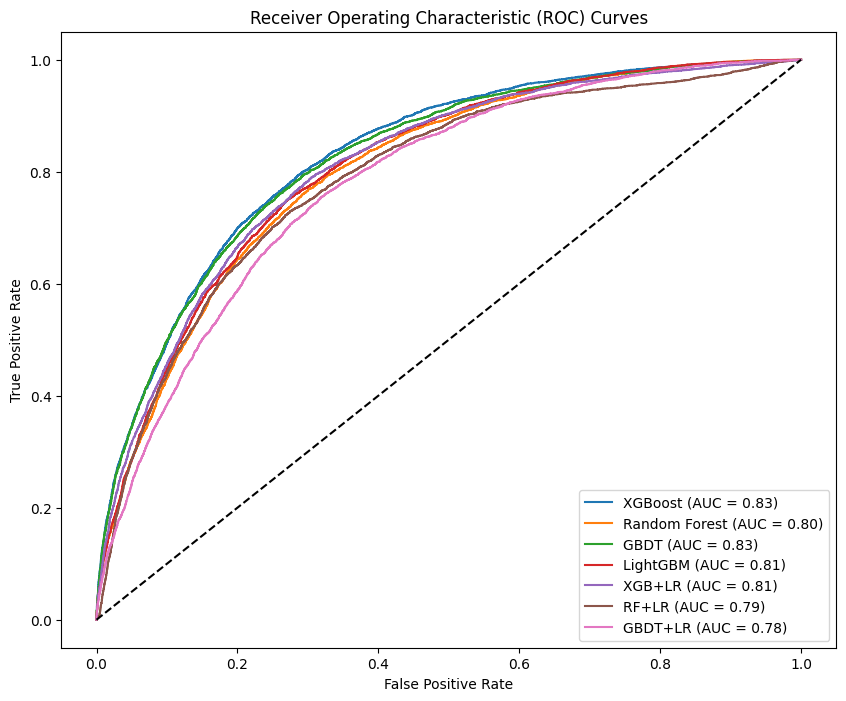

In [27]:
# Plot the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_gbdt, tpr_gbdt, label=f'GBDT (AUC = {auc_gbdt:.2f})')
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {auc_lgb:.2f})')
plt.plot(fpr_xgblr, tpr_xgblr, label=f'XGB+LR (AUC = {auc_xgblr:.2f})')
plt.plot(fpr_rflr, tpr_rflr, label=f'RF+LR (AUC = {auc_rflr:.2f})')
plt.plot(fpr_gbdtlr, tpr_gbdtlr, label=f'GBDT+LR (AUC = {auc_gbdtlr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()

Model Comparision

In [28]:
# Comparing the models

results = {
    'Model': ['XGBoost', 'Random Forest', 'GBDT', 'LightGBM', 'XGB+LR', 'RF+LR', 'GBDT+LR'],
    'Accuracy': [accuracy_xgb, accuracy_rf, accuracy_gbdt, accuracy_lgb, accuracy_xgblr, accuracy_rflr, accuracy_rflr],
    'F1 Score': [f1_xgb, f1_rf, f1_gbdt, f1_lgb, f1_xgblr, f1_rflr, f1_rflr],
    'AUC': [auc_xgb, auc_rf, auc_gbdt, auc_lgb, auc_xgblr, auc_rflr, auc_rflr]
}

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,F1 Score,AUC
0,XGBoost,0.763505,0.551575,0.830012
1,Random Forest,0.700059,0.510148,0.803423
2,GBDT,0.771494,0.549275,0.825022
3,LightGBM,0.721194,0.522098,0.809198
4,XGB+LR,0.745541,0.532246,0.811195
5,RF+LR,0.802984,0.494084,0.790473
6,GBDT+LR,0.802984,0.494084,0.790473


Feature Importance

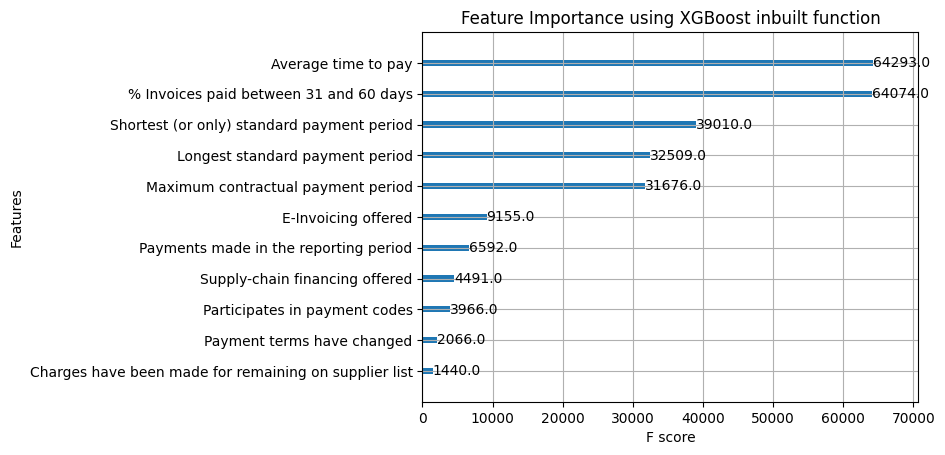

In [29]:
# Feature Importance using XGBoost inbuilt function
xgb.plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [6, 4]
plt.title('Feature Importance using XGBoost inbuilt function') 
plt.show()

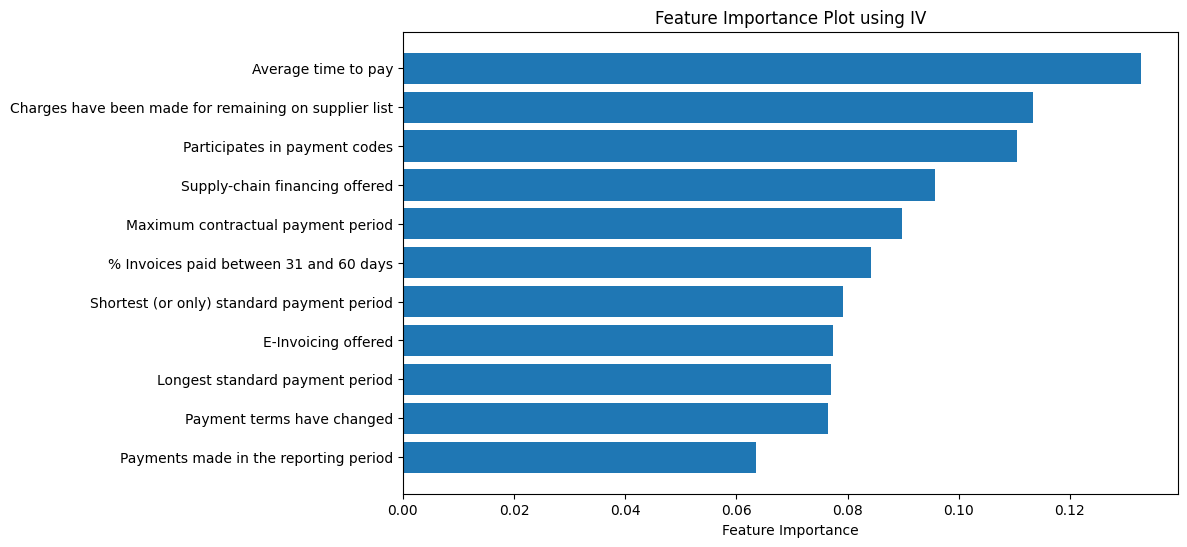

In [30]:
# Feature Importance using Information Value method
# Define the feature names
feature_names = list(X_train.columns)

# Check if feature importances are available
feature_importances = xgb_clf.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance Plot using IV")
plt.show()


Partial Dependency Plots

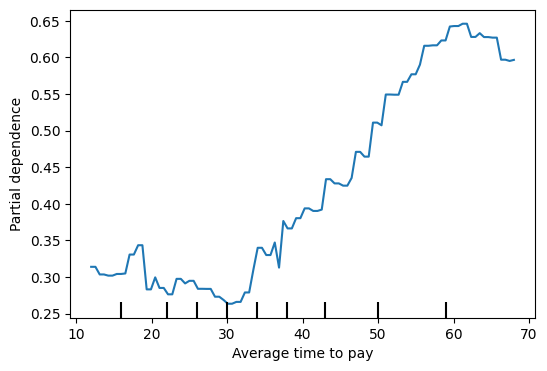

In [31]:
from sklearn.inspection import PartialDependenceDisplay
feature_name = 'Average time to pay'
display = PartialDependenceDisplay.from_estimator(xgb_clf, X_train, features=[feature_name])
display.plot(ax=plt.gca())
plt.show()

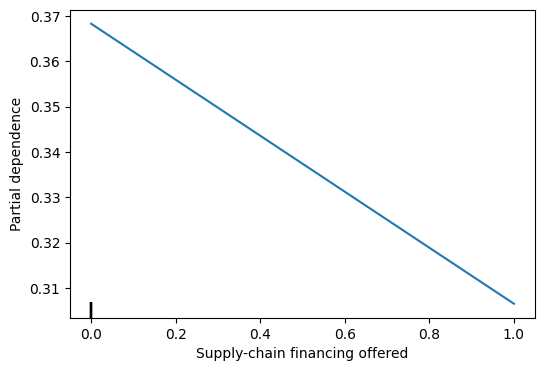

In [32]:
display = PartialDependenceDisplay.from_estimator(xgb_clf, X_train, features=['Supply-chain financing offered'])
display.plot(ax=plt.gca())
plt.show()

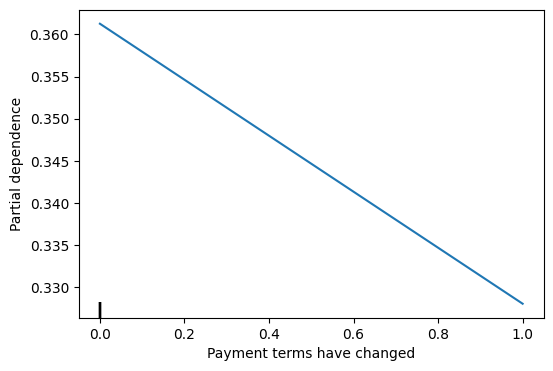

In [33]:
display = PartialDependenceDisplay.from_estimator(xgb_clf, X_train, features=['Payment terms have changed'])
display.plot(ax=plt.gca())
plt.show()

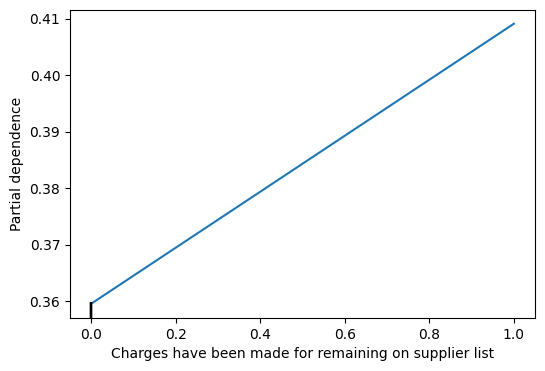

In [34]:
display = PartialDependenceDisplay.from_estimator(xgb_clf, X_train, features=['Charges have been made for remaining on supplier list'])
display.plot(ax=plt.gca())
plt.show()

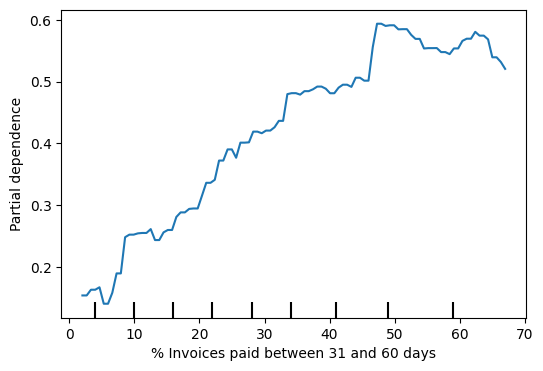

In [35]:
display = PartialDependenceDisplay.from_estimator(xgb_clf, X_train, features=['% Invoices paid between 31 and 60 days'])
display.plot(ax=plt.gca())
plt.show()